# Neural networks - Project 1
## Luis Filipe Menezes - RA: 164924

Este notebook foi feito como entrega para o 1º projeto da disciplina de Redes Neurais do Programa de Pós Gradução em Ciência da Computação (PPG-CC) da Univesidade Federal de São Paulo (UNIFESP).

Este projeto consiste em:

- Selecionar dois datasets (não triviais)

    - Um dataset para **classificação**

    - Um dataset para **regressão**

- Separar em treino/validação/teste

- Treinar modelos MLP para os dois problemas

- Considerar:

    - Diferentes topologias (>=5 topologias, variar número de camadas)
    - Usar o algoritmo original SGD (não usar algoritmos otimizados, e.g.ADAM)
    - Avaliar o impacto do uso do Momentum
    - Avaliar o impacto do uso da regularização (i.e. L2)

- Ilustrar graficamente a evolução do treinamento (treino/validação).

- Confeccionar um relatório (reprodutível) contendo os experimentos e resultados


# Predicting Crocodiles' conservation status

O primeiro problema a ser resolvido consiste em um problema de classificação utilizando um *dataset*
sobre conservação de espécies de crocodilos.

## Upload do dataset

Faremos o upload do *dataset* pela biblioteca **KaggleHub**.


In [19]:
import sys
import subprocess
import pkg_resources

try:
    pkg_resources.get_distribution('kagglehub')
    print("A biblioteca kagglehub já está instalada.")
except pkg_resources.DistributionNotFound:
    print("A biblioteca kagglehub não foi encontrada. Instalando...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub"])
    print("kagglehub instalado com sucesso.")

A biblioteca kagglehub já está instalada.


In [20]:
import kagglehub
import pandas as pd

# Download latest version
def download_and_load_dataset():
    path = kagglehub.dataset_download("zadafiyabhrami/global-crocodile-species-dataset") + "/crocodile_dataset.csv"
    df = pd.read_csv(path)
    return df, path

if __name__ == "__main__":
    df, path = download_and_load_dataset()
    print("Dataset preview: \n", df.info())

Using Colab cache for faster access to the 'global-crocodile-species-dataset' dataset.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Observation ID        1000 non-null   int64  
 1   Common Name           1000 non-null   object 
 2   Scientific Name       1000 non-null   object 
 3   Family                1000 non-null   object 
 4   Genus                 1000 non-null   object 
 5   Observed Length (m)   1000 non-null   float64
 6   Observed Weight (kg)  1000 non-null   float64
 7   Age Class             1000 non-null   object 
 8   Sex                   1000 non-null   object 
 9   Date of Observation   1000 non-null   object 
 10  Country/Region        1000 non-null   object 
 11  Habitat Type          1000 non-null   object 
 12  Conservation Status   1000 non-null   object 
 13  Observer Name         1000 non-null  

## Preparação de dados

Existem 15 atributos no total, no entanto, nem todos podem ser utilizados para classificação, e.g. *Common Name*, *Notes* ou *Family*.

Alguns atributos não faz sentido entregar para o modelo, visto que a correlação teórica é alte (e.g. *Scientific Name*, *Gênero*, se temos o nome científico da espécie, por equivalência também temos seu status de conservação).

In [150]:

cleaned_df = df.drop(columns=['Common Name', 'Notes', 'Family',
                              'Observer Name', 'Scientific Name',
                              'Date of Observation', 'Observation ID', 'Genus', 'Country/Region'])

# Célula para inspecionar as colunas categóricas
categorical_cols = cleaned_df.select_dtypes(include=['object']).columns
print("Colunas categóricas restantes:\n", categorical_cols)
print("\nNúmero de valores únicos por coluna:")
print(cleaned_df[categorical_cols].nunique())

Colunas categóricas restantes:
 Index(['Age Class', 'Sex', 'Habitat Type', 'Conservation Status'], dtype='object')

Número de valores únicos por coluna:
Age Class               4
Sex                     3
Habitat Type           29
Conservation Status     5
dtype: int64


### Codificação e normalização de atributos
Das colunas categóricas restantes, vale a pena observar quais são apropriadas fazer **One-Hot Encoding** (1 de c), isto é, quais são **nominais** e quais são **ordinais**.

In [165]:

cols_nominal = [ 'Conservation Status', 'Habitat Type', 'Sex'] # Categorias nominais

# Aplica o One-Hot Encoding
encoded_df = pd.get_dummies(cleaned_df, columns=cols_nominal)

print("Dimensões do DataFrame após One-Hot Encoding:", encoded_df.shape)
display(encoded_df.head())

Dimensões do DataFrame após One-Hot Encoding: (1000, 40)


,Observed Length (m),Observed Weight (kg),Age Class,Conservation Status_Critically Endangered,Conservation Status_Data Deficient,Conservation Status_Endangered,Conservation Status_Least Concern,Conservation Status_Vulnerable,Habitat Type_Billabongs,Habitat Type_Brackish Rivers,Habitat Type_Coastal Lagoons,Habitat Type_Coastal Wetlands,Habitat Type_Estuaries,Habitat Type_Estuarine Systems,Habitat Type_Flooded Savannas,Habitat Type_Forest Rivers,Habitat Type_Forest Swamps,Habitat Type_Freshwater Marshes,Habitat Type_Freshwater Rivers,Habitat Type_Freshwater Wetlands,Habitat Type_Gorges,Habitat Type_Lagoons,Habitat Type_Lakes,Habitat Type_Large Rivers,Habitat Type_Mangroves,Habitat Type_Marshes,Habitat Type_Oases,Habitat Type_Oxbow Lakes,Habitat Type_Ponds,Habitat Type_Reservoirs,Habitat Type_Rivers,Habitat Type_Shaded Forest Rivers,Habitat Type_Slow Rivers,Habitat Type_Slow Streams,Habitat Type_Small Streams,Habitat Type_Swamps,Habitat Type_Tidal Rivers,Sex_Female,Sex_Male,Sex_Unknown
0,1.90,62.0,Adult,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
1,4.09,334.5,Adult,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,1.08,118.2,Juvenile,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,2.42,90.4,Adult,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
4,3.75,269.4,Adult,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True


In [166]:
cols_ordinal = ['Age Class', 'Conservation Status'] # Categorias ordinais

for col in cols_ordinal:
    print(df[col].value_counts())
    print("\n")

Age Class
Adult        510
Subadult     247
Juvenile     194
Hatchling     49
Name: count, dtype: int64


Conservation Status
Least Concern            384
Critically Endangered    275
Vulnerable               170
Data Deficient           115
Endangered                56
Name: count, dtype: int64




Note que o status de conservação, nossa classe a ser predita, possui uma categoria como *data deficient*, o que é cerca de $11,5$% do nosso conjunto de dados... Isso corresponde à duas especies que não temos dados sobre conservação.

Aqui nos encontramos com duas alternativas:
 - Retirar os dados faltantes.
 - Utilizar este como uma classe independente.

 Como o nosso conjunto de dados é pequeno e o modelo não será aplicado na industria, podemos utilizar estes como uma classe independente por si só.

In [167]:
df['Scientific Name'][cleaned_df['Conservation Status'] == 'Data Deficient'].unique()

array(['Osteolaemus osborni', 'Crocodylus raninus'], dtype=object)

In [168]:
age_class_mapper = {
    "Hatchling": 0,
    "Juvenile": 1,
    "Subadult": 2,
    "Adult": 3
}

encoded_df['Age Class'] = encoded_df['Age Class'].map(age_class_mapper)
display(encoded_df.head())

,Observed Length (m),Observed Weight (kg),Age Class,Conservation Status_Critically Endangered,Conservation Status_Data Deficient,Conservation Status_Endangered,Conservation Status_Least Concern,Conservation Status_Vulnerable,Habitat Type_Billabongs,Habitat Type_Brackish Rivers,Habitat Type_Coastal Lagoons,Habitat Type_Coastal Wetlands,Habitat Type_Estuaries,Habitat Type_Estuarine Systems,Habitat Type_Flooded Savannas,Habitat Type_Forest Rivers,Habitat Type_Forest Swamps,Habitat Type_Freshwater Marshes,Habitat Type_Freshwater Rivers,Habitat Type_Freshwater Wetlands,Habitat Type_Gorges,Habitat Type_Lagoons,Habitat Type_Lakes,Habitat Type_Large Rivers,Habitat Type_Mangroves,Habitat Type_Marshes,Habitat Type_Oases,Habitat Type_Oxbow Lakes,Habitat Type_Ponds,Habitat Type_Reservoirs,Habitat Type_Rivers,Habitat Type_Shaded Forest Rivers,Habitat Type_Slow Rivers,Habitat Type_Slow Streams,Habitat Type_Small Streams,Habitat Type_Swamps,Habitat Type_Tidal Rivers,Sex_Female,Sex_Male,Sex_Unknown
0,1.90,62.0,3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
1,4.09,334.5,3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,1.08,118.2,1,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,2.42,90.4,3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
4,3.75,269.4,3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True


Para **normalização**, vamos observar as classes numéricas.
Para decidir qual método de normalização será utilizado, por distribuição ou utilizando minMaxScaler, precisamos analisar a presença de outliers nos dados numéricos, visto que utilizando o minMaxScaler podemos acabar

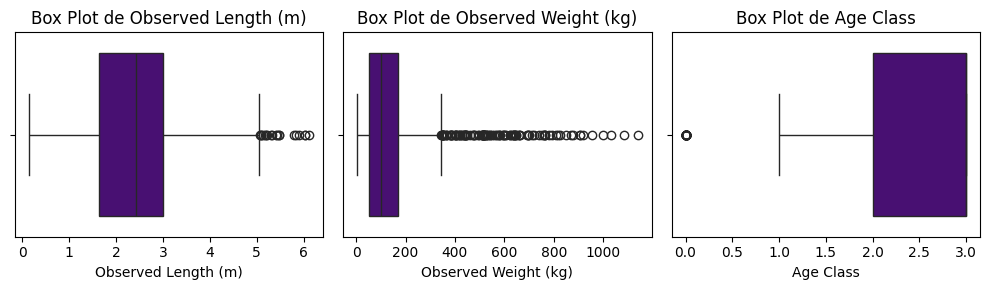

       Observed Length (m)  Observed Weight (kg)    Age Class
count          1000.000000           1000.000000  1000.000000
mean              2.415110            155.771900     2.218000
std               1.097542            175.186788     0.923758
min               0.140000              4.400000     0.000000
25%               1.637500             53.225000     2.000000
50%               2.430000            100.600000     3.000000
75%               3.010000            168.875000     3.000000
max               6.120000           1139.700000     3.000000


In [169]:
numeric_cols = encoded_df.select_dtypes(include=['int', 'float64']).columns

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(10, 3))

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=encoded_df[col], ax=axes[i], color='indigo')
    axes[i].set_title(f'Box Plot de {col}')

plt.tight_layout()
plt.show()
print(encoded_df[numeric_cols].describe())

Como a classe *Observed Weight* possui muitos outliers, vamos utilizar normalização por distribuição, utilizando o módulo *StandartScaler* do *scikitlearn*

In [156]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(encoded_df[numeric_cols])
encoded_df[numeric_cols] = scaler.transform(encoded_df[numeric_cols])
display(encoded_df[numeric_cols].describe())

,Observed Length (m),Observed Weight (kg),Age Class
count,1.000000e+03,1.000000e+03,1.000000e+03
mean,1.136868e-16,7.283063e-17,2.309264e-17
std,1.000500e+00,1.000500e+00,1.000500e+00
min,-2.073951e+00,-8.644924e-01,-2.402262e+00
25%,-7.088557e-01,-5.856504e-01,-2.361106e-01
50%,1.357346e-02,-3.150894e-01,8.469654e-01
75%,5.422914e-01,7.483245e-02,8.469654e-01
max,3.377313e+00,5.619262e+00,8.469654e-01


## Desenvolvimento de modelos

In [157]:
cols_to_predict = ['Conservation Status_Least Concern', 'Conservation Status_Critically Endangered', 'Conservation Status_Endangered', 'Conservation Status_Data Deficient',  'Conservation Status_Vulnerable']

Y = encoded_df[cols_to_predict]
X = encoded_df.drop(columns=cols_to_predict)
X.head()

,Observed Length (m),Observed Weight (kg),Age Class,Habitat Type_Billabongs,Habitat Type_Brackish Rivers,Habitat Type_Coastal Lagoons,Habitat Type_Coastal Wetlands,Habitat Type_Estuaries,Habitat Type_Estuarine Systems,Habitat Type_Flooded Savannas,Habitat Type_Forest Rivers,Habitat Type_Forest Swamps,Habitat Type_Freshwater Marshes,Habitat Type_Freshwater Rivers,Habitat Type_Freshwater Wetlands,Habitat Type_Gorges,Habitat Type_Lagoons,Habitat Type_Lakes,Habitat Type_Large Rivers,Habitat Type_Mangroves,Habitat Type_Marshes,Habitat Type_Oases,Habitat Type_Oxbow Lakes,Habitat Type_Ponds,Habitat Type_Reservoirs,Habitat Type_Rivers,Habitat Type_Shaded Forest Rivers,Habitat Type_Slow Rivers,Habitat Type_Slow Streams,Habitat Type_Small Streams,Habitat Type_Swamps,Habitat Type_Tidal Rivers,Sex_Female,Sex_Male,Sex_Unknown
0,-0.469565,-0.535536,0.846965,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
1,1.526801,1.020725,0.846965,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,-1.217063,-0.214575,-1.319187,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,0.004458,-0.373342,0.846965,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
4,1.216862,0.648936,0.846965,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True


### Divisão do conjunto de dados

Utilizaremos divisão estratificada para preservar a proporção entre as classes.

In [170]:
from sklearn.model_selection import train_test_split

X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.1, random_state=24, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.2, random_state=24, stratify=Y_dev)

print("Tamanho do conjunto de treino:", X_train.shape)
print("Número de classes preditas:", Y_test.shape[1])

Tamanho do conjunto de treino: (720, 35)
Número de classes preditas: 5


### Modelo 0 - MLP sem *momentum*
Utilizando os seguintes hiperparâmetros:
- 5 neurônios na camada oculta.
- $lr= 0.1$
- Divisão estratificada do banco de dados.
- Treinamento em *batch* (tamanho = 100).

In [230]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(5, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))


In [231]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.1, momentum=0.0)

In [232]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 5)              │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210 (840.00 B)

 Trainable params: 210 (840.00 B)

 Non-trainable params: 0 (0.00 B)

In [233]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=100, verbose=0)

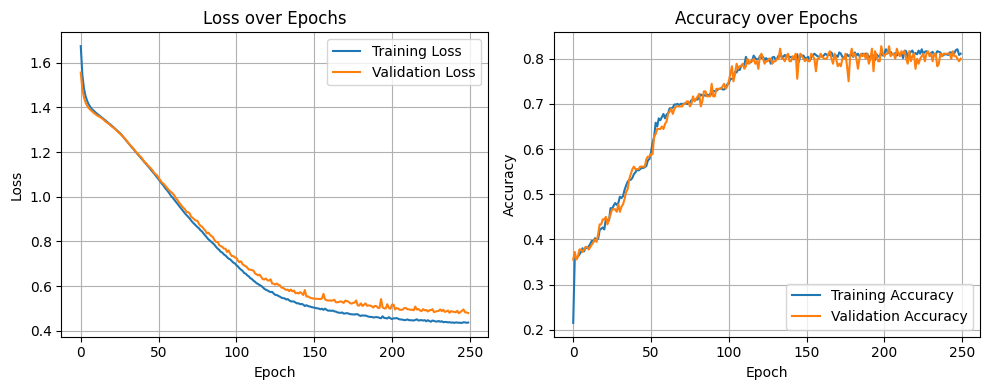

In [196]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [234]:
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7582 - loss: 0.5383 
Validation Loss: 0.5259
Validation Accuracy: 0.7611


#### Comentários:

É possível perceber que o modelo se encontra em *underfitting*, ou seja, os 5 neurônios na camada oculta parecem não ser suficiente para convergir o modelo.

Além disso, visto que o treinamento está sendo em batch, a oscilação entre as épocas deve se dar pela alta taxa de aprendizado.

Vamos portanto aumentar o número de neurônios na camada oculta e avaliar se a camada oculta conseguirá reduzir a dimensionalidade para um $R^5$ linearmente separável.

### Modelo 1 - MLP sem *momentum*
Utilizando os seguintes hiperparâmetros:
- 10 neurônios na camada oculta.
- $lr= 0.1$
- Divisão estratificada do banco de dados.
- Treinamento em *batch* (tamanho = 100).

In [247]:
import keras
from keras.layers import Dense, Input

model = keras.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(15, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))


In [248]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.1, momentum=0.0)

In [249]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 15)             │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620 (2.42 KB)

 Trainable params: 620 (2.42 KB)

 Non-trainable params: 0 (0.00 B)

In [250]:
history = model.fit(X_train, Y_train, epochs=800,
                     validation_data=(X_val, Y_val),
                     batch_size=100, verbose=0,)

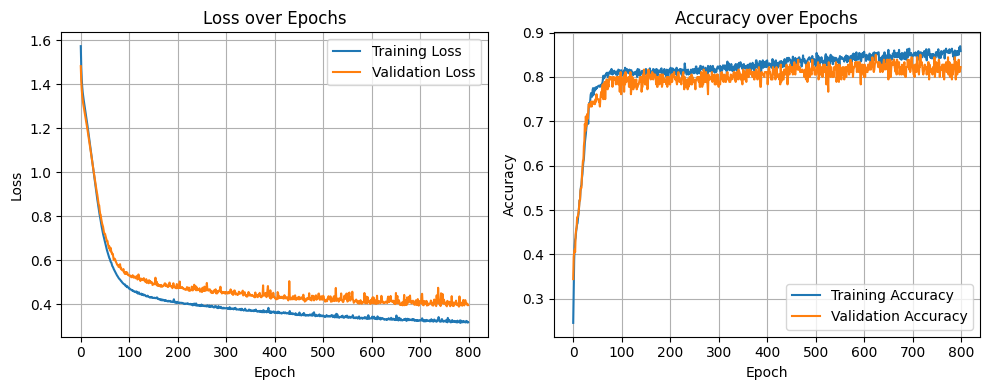

In [251]:
#@title Gráfico de custo durante aprendizado
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

In [246]:
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8288 - loss: 0.3963 
Validation Loss: 0.4049
Validation Accuracy: 0.8278


#### Comentários:

Houve uma melhora na acurácia de validação. O que nos mostra que o modelo pode convergir apenas com um ajuste fino em sua topologia.
